In [1]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Initialize Saprk Session
spark = SparkSession.builder.appName("MovieLens").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 14:12:40 WARN Utils: Your hostname, dothanhdatle, resolves to a loopback address: 127.0.1.1; using 10.188.43.224 instead (on interface wlo1)
25/08/10 14:12:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/10 14:12:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load data
base_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(base_dir, "data", "transformed")

movie_df = spark.read.parquet(os.path.join(data_path,"movies_clean"))
movieByGenre_df = spark.read.parquet(os.path.join(data_path,"movies_by_genre"))
rating_df = spark.read.parquet(os.path.join(data_path,"ratingWithDatetime"))
user_df = spark.read.parquet(os.path.join(data_path,"usersData"))

In [4]:
movie_df.printSchema()
movieByGenre_df.printSchema()
rating_df.printSchema()
user_df.printSchema()

root
 |-- movieID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- year: integer (nullable = true)

root
 |-- movieID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genre: string (nullable = true)

root
 |-- userID: integer (nullable = true)
 |-- movieID: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- datetime: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

root
 |-- userID: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: integer (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- age_group: string (nullable = true)



In [5]:
movie_df.show(3,truncate=False)
movieByGenre_df.show(3, truncate=False)
rating_df.show(3, truncate=False)
user_df.show(3, truncate=False)

+-------+--------------------------------------+--------------------------+----+
|movieID|title                                 |genres                    |year|
+-------+--------------------------------------+--------------------------+----+
|169    |Free Willy 2: The Adventure Home      |Adventure|Children's|Drama|1995|
|191    |Scarlet Letter, The                   |Drama                     |1995|
|891    |Halloween: The Curse of Michael Myers |Horror|Thriller           |1995|
+-------+--------------------------------------+--------------------------+----+
only showing top 3 rows
+-------+---------------------------------+----+----------+
|movieID|title                            |year|genre     |
+-------+---------------------------------+----+----------+
|169    |Free Willy 2: The Adventure Home |1995|Adventure |
|169    |Free Willy 2: The Adventure Home |1995|Children's|
|169    |Free Willy 2: The Adventure Home |1995|Drama     |
+-------+---------------------------------+----+-

**Some analysis**

In [6]:
# Top most rated movies
movie_rated_counts = rating_df.groupBy("movieID")\
    .agg(func.count("*").alias("rating_counts"))\
        .join(movie_df.select("movieID","title"),on="movieID",how="inner")\
            .select("movieID","title","rating_counts")\
                .orderBy(func.desc("rating_counts"))
movie_rated_counts.show(5, truncate=False)

+-------+-----------------------------------------------+-------------+
|movieID|title                                          |rating_counts|
+-------+-----------------------------------------------+-------------+
|2858   |American Beauty                                |3428         |
|260    |Star Wars: Episode IV - A New Hope             |2991         |
|1196   |Star Wars: Episode V - The Empire Strikes Back |2990         |
|1210   |Star Wars: Episode VI - Return of the Jedi     |2883         |
|480    |Jurassic Park                                  |2672         |
+-------+-----------------------------------------------+-------------+
only showing top 5 rows


In [7]:
# Average rating per genre
avg_rate_genre = movieByGenre_df.join(rating_df.select("movieID","rating"), on="movieID", how="left")\
    .groupBy("genre").agg(func.round(func.avg("rating"),2).alias("avg_rating"))\
        .select("genre","avg_rating")\
            .orderBy(func.desc("avg_rating"))
avg_rate_genre.show(10)

+-----------+----------+
|      genre|avg_rating|
+-----------+----------+
|  Film-Noir|      4.08|
|Documentary|      3.93|
|        War|      3.89|
|      Drama|      3.77|
|      Crime|      3.71|
|  Animation|      3.68|
|    Mystery|      3.67|
|    Musical|      3.67|
|    Western|      3.64|
|    Romance|      3.61|
+-----------+----------+
only showing top 10 rows


In [8]:
# Rating Trends Over Time
rating_over_year = rating_df.groupBy("year").agg(func.avg("rating").alias("avg_rating")).orderBy("year")
rating_over_year.show()

+----+------------------+
|year|        avg_rating|
+----+------------------+
|2000|3.5904041135333435|
|2001| 3.512130290480806|
|2002| 3.458828911253431|
|2003| 3.486559139784946|
+----+------------------+



In [9]:
# Most Active Users
user_ratings = rating_df.groupBy("userID").agg(func.count("rating").alias("rating_counts"))\
    .join(user_df, on="userID", how="inner")\
    .orderBy(func.desc("rating_counts"))
user_ratings.show()

+------+-------------+------+---+----------+----------+---------+
|userID|rating_counts|gender|age|occupation|   zipcode|age_group|
+------+-------------+------+---+----------+----------+---------+
|  4169|         2314|     M| 50|         0|     66048|    50-55|
|  1680|         1850|     M| 25|        20|     95380|    25-34|
|  4277|         1743|     M| 35|        16|     98133|    35-44|
|  1941|         1595|     M| 35|        17|     94550|    35-44|
|  1181|         1521|     M| 35|         7|     20716|    35-44|
|   889|         1518|     M| 45|        20|     10024|    45-49|
|  3618|         1344|     M| 56|        17|     22657|      56+|
|  2063|         1323|     M| 25|         4|     43138|    25-34|
|  1150|         1302|     F| 25|        20|     75226|    25-34|
|  1015|         1286|     M| 35|         3|     11220|    35-44|
|  5795|         1277|     M| 25|         1|     92688|    25-34|
|  4344|         1271|     M| 25|         1|     44240|    25-34|
|  1980|  

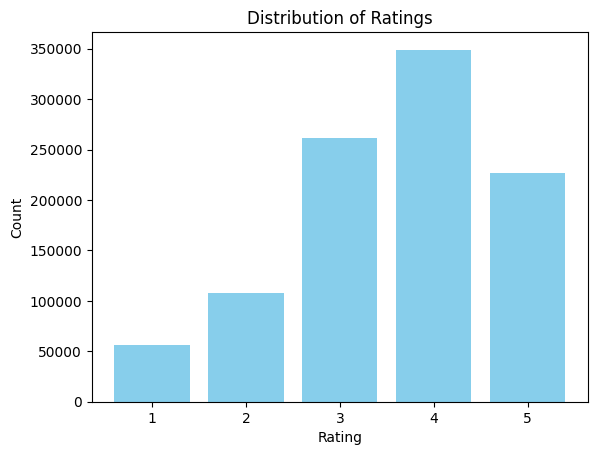

In [ ]:
# Distribution of ratings
rating_distribution = rating_df.groupBy("rating").count().orderBy("rating")

# Convert to pandas
rating_pd = rating_distribution.toPandas()

# Plot histogram
plt.bar(rating_pd['rating'], rating_pd['count'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.show()


In [ ]:
# Ratings over different genre of each age group
rating_genre_df = rating_df.join(movieByGenre_df.select("movieID", "genre"), on="movieID", how="inner")
full_df = rating_genre_df.join(user_df.select("userID", "age_group"), on="userID", how="inner")

pivot_df = full_df.groupBy("genre")\
    .pivot("age_group")\
        .agg(func.round(func.avg("rating"), 2))\
            .orderBy("genre")

pivot_df.show(truncate=False)

+-----------+-----+-----+-----+-----+-----+----+--------+
|genre      |18-24|25-34|35-44|45-49|50-55|56+ |Under 18|
+-----------+-----+-----+-----+-----+-----+----+--------+
|Action     |3.45 |3.45 |3.54 |3.53 |3.61 |3.61|3.51    |
|Adventure  |3.41 |3.44 |3.52 |3.53 |3.63 |3.65|3.45    |
|Animation  |3.62 |3.7  |3.74 |3.73 |3.78 |3.76|3.48    |
|Children's |3.29 |3.43 |3.52 |3.53 |3.56 |3.62|3.24    |
|Comedy     |3.46 |3.49 |3.56 |3.59 |3.65 |3.65|3.5     |
|Crime      |3.67 |3.68 |3.73 |3.75 |3.81 |3.83|3.71    |
|Documentary|3.87 |3.95 |3.95 |3.97 |3.91 |3.96|3.73    |
|Drama      |3.72 |3.73 |3.78 |3.78 |3.88 |3.93|3.79    |
|Fantasy    |3.35 |3.45 |3.48 |3.53 |3.58 |3.53|3.32    |
|Film-Noir  |4.0  |4.06 |4.06 |4.11 |4.18 |4.13|4.15    |
|Horror     |3.17 |3.2  |3.28 |3.26 |3.16 |3.25|3.25    |
|Musical    |3.56 |3.62 |3.72 |3.74 |3.8  |3.89|3.57    |
|Mystery    |3.53 |3.61 |3.7  |3.75 |3.89 |3.89|3.63    |
|Romance    |3.53 |3.55 |3.65 |3.69 |3.76 |3.82|3.62    |
|Sci-Fi     |3